<a href="https://colab.research.google.com/github/shishir-joshi/notebooks/blob/master/Google_GStore_Data_transaction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.random.set_seed(123)

TensorFlow 2.x selected.


In [0]:
# Load dataset.
data = pd.read_csv('https://storage.googleapis.com/sample_user_behavior_data/sample_user_data.csv')

dftrain, dftest = train_test_split(data,test_size=0.3)
dftrain, dfeval = train_test_split(dftrain,test_size=0.2)

_=dftrain.pop('fullVisitorId')
_=dftest.pop('fullVisitorId')
_=dfeval.pop('fullVisitorId')

y_train = dftrain.pop('totals_totalTransactionRevenue').to_frame()
y_test = dftest.pop('totals_totalTransactionRevenue').to_frame()
y_eval = dfeval.pop('totals_totalTransactionRevenue').to_frame()

y_train.fillna(0,inplace=True)
y_test.fillna(0,inplace=True)
y_eval.fillna(0,inplace=True)

dftrain.fillna(0,inplace=True)
dftest.fillna(0,inplace=True)
dfeval.fillna(0,inplace=True)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


*NOTE:*

*As the task is to predict whether a visitor will make a* *transaction or not, I have converted the target variable from* *numeric to binary(o = no revenue, 1 = some revenue)*

In [0]:

y_train.loc[y_train.totals_totalTransactionRevenue > 0, 'totals_totalTransactionRevenue'] = 1
y_test.loc[y_test.totals_totalTransactionRevenue > 0, 'totals_totalTransactionRevenue'] = 1
y_eval.loc[y_eval.totals_totalTransactionRevenue > 0, 'totals_totalTransactionRevenue'] = 1

## Exploring the data

Plotting visitors against the sum of transaction revenue per customer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


<Figure size 1000x1000 with 0 Axes>

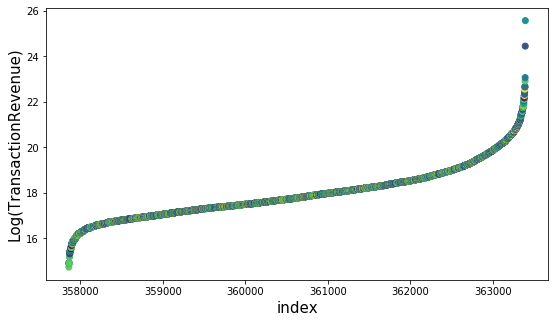

In [0]:
data['totals_totalTransactionRevenue'] = data['totals_totalTransactionRevenue'].astype('float')
to_plot = data.groupby('fullVisitorId')['totals_totalTransactionRevenue'].sum().reset_index()
fig=plt.figure(figsize=(10,10), dpi= 100, facecolor='w', edgecolor='k')
colors = np.random.rand(to_plot.shape[0])
plt.figure(figsize=(9,5))
plt.scatter(range(to_plot.shape[0]), np.log(np.sort(to_plot['totals_totalTransactionRevenue'].values)), c=colors)
plt.xlabel('index', fontsize=15)
plt.ylabel('Log(TransactionRevenue)', fontsize=15)
plt.show()

Plotting total time on site against Revenue

<Figure size 1000x1000 with 0 Axes>

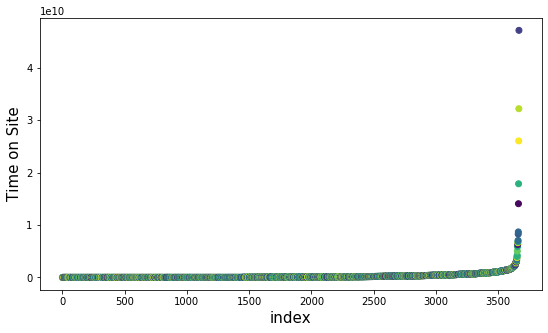

In [0]:
fig=plt.figure(figsize=(10,10), dpi= 100, facecolor='w', edgecolor='k')
to_plot = data.groupby('totals_timeOnSite')['totals_totalTransactionRevenue'].sum().reset_index()
colors = np.random.rand(to_plot.shape[0])
plt.figure(figsize=(9,5))
plt.scatter(range(to_plot.shape[0]), (np.sort(to_plot['totals_totalTransactionRevenue'].values)), c=colors)
plt.xlabel('index', fontsize=15)
plt.ylabel('Time on Site', fontsize=15)
# dftrain.totals_timeOnSite.hist(figsize=(5,4),bins=4)
plt.show()

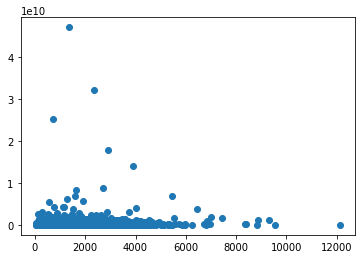

In [0]:
plt.scatter(data['totals_timeOnSite'],data['totals_totalTransactionRevenue'])

Which channels bring the most visitors:

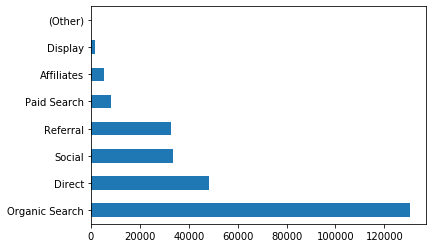

In [0]:
dftrain.channelGrouping.value_counts().plot(kind='barh')
plt.show()

Plotting the revenue from specific data sources, 
direct and google seem to dominate the total revenue streams

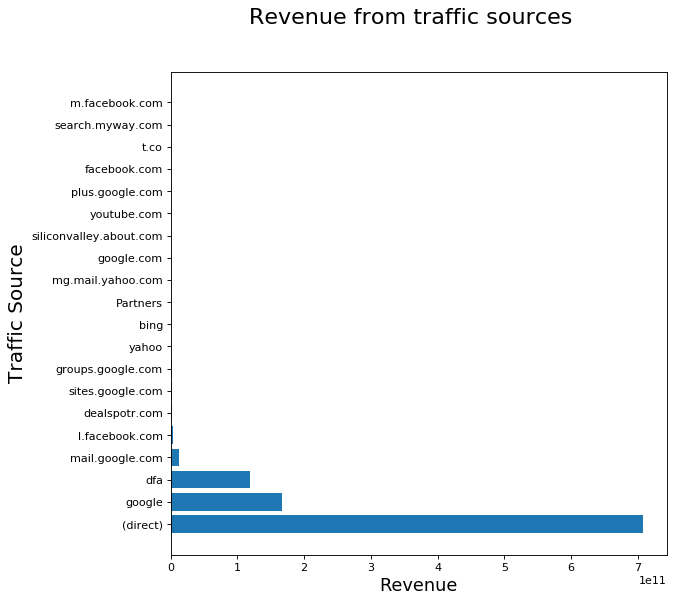

In [0]:
ind = np.arange(len(data.groupby('trafficSource_source')))
width = 5
fig=plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('Revenue from traffic sources', fontsize=20)
plt.ylabel('Traffic Source', fontsize=18)
plt.xlabel('Revenue', fontsize=16)
to_plot = data.groupby('trafficSource_source')['totals_totalTransactionRevenue'].sum().reset_index()
to_plot = to_plot.sort_values(by='totals_totalTransactionRevenue')[::-1][:20]
plt.yticks(ind[:20], to_plot['trafficSource_source'], rotation = -360)

bar = plt.barh(ind[:20], to_plot['totals_totalTransactionRevenue'])

###Dataset Summary Statistics

In [0]:
dftrain.head()

,visitNumber,date,visitStartTime,totals_bounces,totals_pageviews,totals_timeOnSite,totals_transactions,trafficSource_source,trafficSource_medium,trafficSource_campaign,device_deviceCategory,device_operatingSystem,device_mobileDeviceModel,geoNetwork_city,channelGrouping
156944,1,20170603,1496557210,0.0,3.0,41.0,0.0,(direct),(none),(not set),tablet,Android,not available in demo dataset,not available in demo dataset,Direct
191023,1,20170630,1498806257,0.0,10.0,127.0,0.0,youtube.com,referral,(not set),mobile,Android,not available in demo dataset,Chennai,Social
304487,1,20170129,1485702353,1.0,1.0,0.0,0.0,quora.com,referral,(not set),desktop,Windows,not available in demo dataset,not available in demo dataset,Social
350015,1,20170708,1499511926,1.0,1.0,0.0,0.0,google,organic,(not set),mobile,Android,not available in demo dataset,(not set),Organic Search
174144,1,20170226,1488141142,0.0,4.0,52.0,0.0,google,organic,(not set),mobile,iOS,not available in demo dataset,not available in demo dataset,Organic Search


In [0]:
dftrain.describe(include='all')

,visitNumber,date,visitStartTime,totals_bounces,totals_pageviews,totals_timeOnSite,totals_transactions,trafficSource_source,trafficSource_medium,trafficSource_campaign,device_deviceCategory,device_operatingSystem,device_mobileDeviceModel,geoNetwork_city,channelGrouping
count,260233.000000,2.602330e+05,2.602330e+05,260233.000000,260233.000000,260233.000000,260233.000000,260233,260233,260233,260233,260233,260233,260233,260233
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184,7,7,3,16,1,435,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(direct),(none),(not set),desktop,Windows,not available in demo dataset,not available in demo dataset,Organic Search
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104926,104924,250031,175487,95968,260233,150305,130422
mean,2.345221,2.017042e+07,1.492489e+09,0.501405,3.763377,138.774314,0.014157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,10.014187,2.008002e+02,5.283608e+06,0.499999,6.279368,371.015187,0.132951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,2.017010e+07,1.483258e+09,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,2.017022e+07,1.487893e+09,0.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.000000,2.017042e+07,1.492441e+09,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,2.017061e+07,1.497097e+09,1.000000,4.000000,93.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
dftrain.shape[0], dfeval.shape[0], dftest.shape[0]

(260233, 65059, 139412)

## Create feature columns and input functions
The Gradient Boosted Trees Classifier needs utilize both numeric and categorical features. 
Need to make define feature columns as categorical and numeric features

In [0]:
dftrain.dtypes

visitNumber                   int64
date                          int64
visitStartTime                int64
totals_bounces              float64
totals_pageviews            float64
totals_timeOnSite           float64
totals_transactions         float64
trafficSource_source         object
trafficSource_medium         object
trafficSource_campaign       object
device_deviceCategory        object
device_operatingSystem       object
device_mobileDeviceModel     object
geoNetwork_city              object
channelGrouping              object
dtype: object

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['trafficSource_source','trafficSource_medium',
       'trafficSource_campaign', 'device_deviceCategory',
       'device_operatingSystem', 'device_mobileDeviceModel', 'geoNetwork_city',
       'channelGrouping']
NUMERIC_COLUMNS = ['visitNumber', 'date', 'visitStartTime', 'totals_bounces', 'totals_pageviews', 'totals_timeOnSite',
                   'totals_transactions']

def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

feature_columns = []
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name))
  
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  # print(vocabulary)
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))


In [0]:
# For Boosted Tree need to define tf.Data dataset in input function
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)
print(NUM_EXAMPLES)
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
test_input_fn = make_input_fn(dftest, y_test, shuffle=False, n_epochs=1)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)


260233


## Train and evaluate the model


###Training a Basic Decision Tree classifier first

In [0]:
from sklearn import tree

In [0]:
train_tree_input = tf.keras.layers.DenseFeatures(feature_columns)(dict(dftrain)).numpy()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_tree_input,y_train)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


In [0]:
eval_tree_input = tf.keras.layers.DenseFeatures(feature_columns)(dict(dfeval)).numpy()
eval_preds = clf.predict(eval_tree_input)

In [0]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_eval, eval_preds),
    columns=['Predicted No Transaction', 'Predicted Transaction'],
    index=['True No Transaction', 'True Transaction']
)

,Predicted No Transaction,Predicted Transaction
True No Transaction,64145,0
True Transaction,0,914


In [0]:
test_tree_input = tf.keras.layers.DenseFeatures(feature_columns)(dict(dftest)).numpy()
test_preds = clf.predict(test_tree_input)

In [0]:
pd.DataFrame(
    confusion_matrix(y_test, test_preds),
    columns=['Predicted No Transaction', 'Predicted Transaction'],
    index=['True No Transaction', 'True Transaction']
)

,Predicted No Transaction,Predicted Transaction
True No Transaction,137552,0
True Transaction,0,1860


In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, test_preds)

1.0

### Boosted Trees model. 




In [0]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset.
n_batches = 1

est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

est.train(train_input_fn, max_steps=70)

# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                 1.000000
accuracy_baseline        0.985951
auc                      1.000000
auc_precision_recall     1.000000
average_loss             0.000440
label/mean               0.014049
loss                     0.000440
precision                1.000000
prediction/mean          0.014476
recall                   1.000000
global_step             70.000000
dtype: float64


Plotting the performance on test data

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphh2lhufz/model.ckpt-70
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


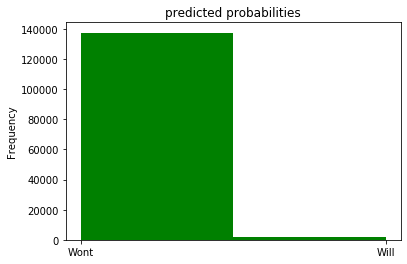

In [0]:
pred_dicts = list(est.predict(test_input_fn))

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

# print(pred_dicts)
ind = [0.0,1.0]
plt.xticks(ind, ('Wont', 'Will'))

probs.plot(kind='hist', bins=2, title='predicted probabilities', colors='green')
plt.show()

##Plotting the ROC for both


Plotting the Receiver Operating Characteristic (ROC) of the results

Given the size of the dataset it is likely there is overfitting in the results, 
as such given more data and better models, a generalized classifier can be made.

First for Basic Decision Tree:

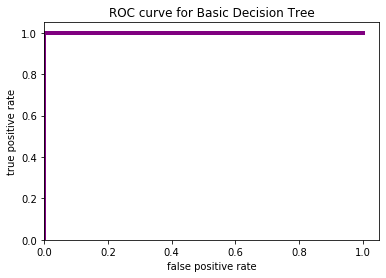

In [0]:
from sklearn.metrics import roc_curve
# Gradienr Boosted Tree
fpr, tpr, _ = roc_curve(y_test, test_preds)
# fig=plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(fpr, tpr, color='purple', linewidth=4)
plt.title('ROC curve for Basic Decision Tree')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

For Boosted Tree Classifier:

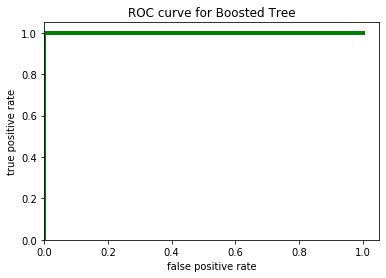

In [0]:
from sklearn.metrics import roc_curve
# Gradienr Boosted Tree
fpr, tpr, _ = roc_curve(y_test, probs)
# fig=plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(fpr, tpr, color='green', linewidth=4)
plt.title('ROC curve for Boosted Tree')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()

##rough

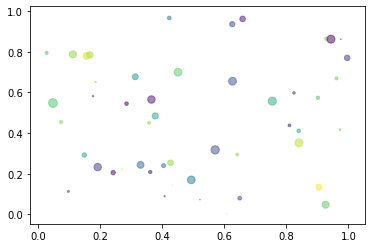

In [0]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (5 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()


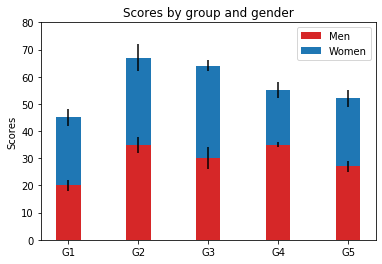

In [0]:
# a stacked bar plot with errorbars
import numpy as np
import matplotlib.pyplot as plt


N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, color='#d62728', yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()
